# LLM 파인튜닝 및 RAG 기반 불공정 약관 탐지 및 법률 근거 제시 시스템

사용자가 약관 원문 조항을 검색하면 시스템은 다음과 같은 과정을 거쳐 결과를 출력한다.

1. 사용자가 입력한 약관 조항을 파인튜닝된 Llama-3.1 모델이 분석하여, **해당 조항의 계약 분야**와 **불공정 여부**를 판별하고, 불공정 여부 판별 결과가 '불리'이면 그 이유를 서술한 **법률적 판단 근거**를 생성한다.


2. 법령 검색을 위하여 쿼리를 생성한다. 이 때 단순 약관 원문을 쿼리로 사용하는 것이 아닌 앞서 LLM이 생성한 **'법률적 판단 근거' 텍스트를 원문과 결합하여 검색 쿼리를 확장**한다.


3. 확장된 쿼리를 법률 도메인에 맞춰 파인튜닝된 **KURE-v1기반 Retriever**에 입력하여, 해당 약관이 위반했을 가능성이 가장 높은 **약관 규제법 조항**을 탐색한다.

완성된 시스템은 다음과 같다.

In [2]:
import argparse
import json
import os
import faiss
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from sentence_transformers import SentenceTransformer

INDEX_PATH = "rag_index_retriever/faiss.index"
META_PATH  = "rag_index_retriever/meta.pkl"          
SFT_DIR    = "models/llama31-8b-sft-fold1"        
#EMB_MODEL  = "nlpai-lab/KURE-v1"
EMB_MODEL = "models/kure-law-retriever"                     


def load_index_and_meta():
    import pickle
    print("FAISS 인덱스 로딩 중...") 
    if not os.path.exists(INDEX_PATH) or not os.path.exists(META_PATH):
        print(f"오류: 인덱스 파일을 찾을 수 없습니다. ({INDEX_PATH}, {META_PATH})")
        return None, None
        
    index = faiss.read_index(INDEX_PATH)
    with open(META_PATH, "rb") as f:
        meta = pickle.load(f)
    print(" 인덱스/메타데이터 로드 완료.")
    return index, meta

def load_sft_model():
    import os
    from peft import PeftModel
    from transformers import BitsAndBytesConfig
    
    print("LLM 모델 로딩 중...") 

    HF_TOKEN = os.environ.get("HF_TOKEN")  
    BASE_MODEL = "meta-llama/Meta-Llama-3.1-8B-Instruct"
    ADAPTER_DIR = SFT_DIR  # 상단 상수 사용

    bnb_cfg = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.float16,
        bnb_4bit_use_double_quant=True,
    )

    tok = AutoTokenizer.from_pretrained(BASE_MODEL, use_fast=True, token=HF_TOKEN)
    if tok.pad_token is None:
        tok.pad_token = tok.eos_token

    base = AutoModelForCausalLM.from_pretrained(
        BASE_MODEL,
        quantization_config=bnb_cfg,
        attn_implementation="sdpa",
        device_map="auto",
        torch_dtype=torch.float16,
        token=HF_TOKEN,
    )

    model = PeftModel.from_pretrained(base, ADAPTER_DIR)

    print(" LLM 모델 로드 완료.")
    return tok, model

def load_embedder():
    print("임베딩 모델 로딩 중...") 
    return SentenceTransformer(EMB_MODEL) 

@torch.no_grad()
def run_sft(tok, mdl, clause_text: str) -> str:
    system = (
        "당신은 약관의 공정성을 분석하는 법률 전문가입니다.\n"
        "문맥상 주체 (고객/ 사업자) 를 명확히 구분하세요.\n"
        "반드시 아래 한 줄 포맷만 출력하세요:\n"
        "분야: <정수> / 불공정여부: <유리|불리> / 근거: <간결한 문장 또는 '해당 없음'>"
    )
    user = f"다음 약관 조항의 문맥을 이해하여 분야 분류, 불공정 여부 판단, 판단 근거를 요약하시오.\n\n입력:\n{clause_text}"

    chat = [
        {"role": "system", "content": system},
        {"role": "user", "content": user}
    ]
    prompt = tok.apply_chat_template(chat, tokenize=False, add_generation_prompt=True)
    inputs = tok(prompt, return_tensors="pt").to(mdl.device)
    out_ids = mdl.generate(
        **inputs, 
        max_new_tokens=256, 
        do_sample=False
    )
    out_txt = tok.decode(out_ids[0], skip_special_tokens=True)
    ans = out_txt.split("assistant\n")[-1].strip()
    return ans

def parse_reason(answer_line: str) -> str:
    parts = [p.strip() for p in answer_line.split("/") if p.strip()]
    reason = ""
    for p in parts:
        if p.startswith("근거:"):
            reason = p.replace("근거:", "").strip()
            break
    return reason

def embed(embedder, texts):
    embs = embedder.encode(texts, normalize_embeddings=True)
    return np.asarray(embs, dtype="float32")

def search(index, query_vec, topk=5):
    D, I = index.search(query_vec, topk)
    return I[0], D[0]

def build_report(clause_text, sft_answer, meta, hits=None, similarities=None):
    answer_str = sft_answer.strip()
    is_unfair = "불공정여부: 불리" in answer_str

    report = {
        "input_clause": clause_text,
        "llm_output": answer_str,
    }

    laws = []
    if is_unfair and hits is not None and len(hits) > 0:
        if similarities is not None and len(similarities) == len(hits):
            hit_data = zip(hits, similarities)
        else:
            hit_data = zip(hits, [None] * len(hits))

        for idx, sim in hit_data:
            if idx < 0 or idx >= len(meta): continue 
            
            rec = meta[int(idx)]
            law_entry = {
                "law_text": rec.get("law_text"),
                "similarity": float(sim) if sim is not None else None
            }
            laws.append(law_entry)
            
    report["retrieved_laws"] = laws
    return report


def main():
    print("===" * 20)
    print("   불공정 약관 분석 도우미   ")
    print("===" * 20)

    #  모델 및 데이터 로드
    try:
        index, meta = load_index_and_meta()
        if index is None: return

        tok, mdl = load_sft_model()
        embedder = load_embedder()
        print("\n모든 모델 로드 완료\n")
    except Exception as e:
        print(f"\n[치명적 오류] 모델 로딩 실패: {e}")
        return

    #  사용자 입력 루프
    while True:
        print("-" * 60)
        clause = input("분석할 약관 조항을 입력하세요 (종료하려면 'q' 또는 'exit' 입력):\n>> ")
        
        if clause.lower() in ['q', 'exit', 'quit']:
            print("프로그램을 종료합니다.")
            break
        
        if not clause.strip():
            print("! 내용을 입력해주세요.")
            continue

        print("\n... 분석 중입니다 ...\n")
        
        try:
            # SFT 추론
            answer = run_sft(tok, mdl, clause)
            reason = parse_reason(answer)

            # 불공정(불리) 판정 시에만 RAG 검색 수행
            if "불공정여부: 유리" in answer:
                report = build_report(clause, answer, meta, hits=None, similarities=None)
            else:
                fused_query = f"{clause}\n\n판단근거: {reason}" if reason else clause
                qv = embed(embedder, [fused_query])
                ids, similarities = search(index, qv, topk=5)
                report = build_report(clause, answer, meta, hits=ids, similarities=similarities)

            # 결과 출력 
            print("\n[분석 결과]")
            print(json.dumps(report, indent=2, ensure_ascii=False))
            
        except Exception as e:
            print(f"분석 중 오류 발생: {e}")

if __name__ == "__main__":
    main()

   불공정 약관 분석 도우미   
FAISS 인덱스 로딩 중...
 인덱스/메타데이터 로드 완료.
LLM 모델 로딩 중...


`torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 4/4 [00:48<00:00, 12.02s/it]


 LLM 모델 로드 완료.
임베딩 모델 로딩 중...

모든 모델 로드 완료

------------------------------------------------------------

... 분석 중입니다 ...



The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



[분석 결과]
{
  "input_clause": "제4조 (약관 외 준칙) 3. 모든 회비는 선불이며 계약 해지시 1일 회원으로 자동계약되고 1일 회원의 회비가 계산되면 해약시 10퍼센트의 부가세와 20퍼센트의 위약금을 차감한 다음 회비를 반려합니다.",
  "llm_output": "분야: 39 / 불공정여부: 불리 / 근거: 해당 약관조항은 고객에게 부당하게 과중한 손해배상의무를 부담시키는 조항이자 계약의 해제 또는 해지로 인한 고객의 원상회복청구권을 부당하게 포기하도록 하는 조항이다.",
  "retrieved_laws": [
    {
      "law_text": "제9조(계약의 해제, 해지) \n계약의 해제, 해지에 관하여 정하고 있는 약관의 내용 중 다음 각 호의 어느 하나에 해당되는 내용을 정하고 있는 조항은 무효로 한다.\n  5. 계약의 해제 또는 해지로 인한 사업자의 원상회복의무나 손해배상의무를 부당하게 경감하는 조항",
      "similarity": 0.6039097905158997
    },
    {
      "law_text": "제8조(손해배상액의 예정) 고객에게 부당하게 과중한 지연 손해금 등의 손해배상 의무를 부담시키는 약관 조항은 무효로 한다.",
      "similarity": 0.599277913570404
    },
    {
      "law_text": "제9조(계약의 해제 , 해지) 계약의 해제 , 해지에 관하여 정하고 있는 약관의 내용 중 다음 각 호의 어느 하나에 해당되는 내용을 정하고 있는 조항은 무효로 한다.\n4. 계약의 해제 또는 해지로 인한 원상회복의무를 상당한 이유 없이 고객에게 과중하게 부담시키거나 고객의 원상회복 청구권을 부당하게 포기하도록 하는 조항",
      "similarity": 0.5774555206298828
    },
    {
      "law_text": "제17조(불공정약관조항의 사용금지) 사업자는 제6조부터 제14조까지의 규정에 해당하는 불공정한 약관

다음은 Llama-3.1-8B-Instruct 모델을 파인튜닝하는 코드이다.

BitsAndBytes 라이브러리를 통해 Meta-Llama-3.1-8B 모델을 4-bit NF4 형식으로 양자화하여 로드함으로써 VRAM 사용량을 최소화하였다.

Peft 라이브러리의 LoraConfig를 사용하여, 모델의 전체 파라미터 중 Attention 모듈과 FFN 레이어에만 Rank 8의 LoRA 어댑터를 적용하였다. 이를 통해 전체 파라미터의 1% 미만만을 학습시키면서도 도메인 특화 성능을 확보하였다.

System Prompt를 통해 모델의 역할을 '법률 전문가'로 정의하고 출력 형식을 고정하였으며, Chat Template을 적용하여 대화형 구조로 데이터를 전처리하였다. 학습 과정에서는 Gradient Accumulation과 Mixed Precision을 활용하여 학습 안정성과 속도를 동시에 확보하였다.

In [ ]:
import torch, os, json, pandas as pd
from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from trl import SFTTrainer, SFTConfig

MY_TOKEN = os.environ.get("HF_TOKEN")            
BASE_MODEL = "meta-llama/Meta-Llama-3.1-8B-Instruct"
MAX_SEQ_LEN = 512
OUTPUT_DIR = "models/llama31-8b-sft-fold10"

os.environ["TORCH_COMPILE_DISABLE"] = "1"

bnb_cfg = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,    
    bnb_4bit_use_double_quant=True,
)

print(f"'{BASE_MODEL}' 로드 중 ...")
tok = AutoTokenizer.from_pretrained(BASE_MODEL, use_fast=True, token=MY_TOKEN)
if tok.pad_token is None:
    tok.pad_token = tok.eos_token

mdl = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    quantization_config=bnb_cfg,
    attn_implementation="sdpa",             
    device_map="auto",
    dtype=torch.float16,
    token=MY_TOKEN,
)
print("--- 모델 로딩 완료 ---")

mdl = prepare_model_for_kbit_training(mdl)

lora_cfg = LoraConfig(
    r=8, lora_alpha=16, lora_dropout=0.05,
    target_modules=["q_proj","k_proj","v_proj",
                    "o_proj","gate_proj","up_proj","down_proj"],
    bias="none", task_type="CAUSAL_LM",
)
mdl = get_peft_model(mdl, lora_cfg)

TRAIN_PATH = "data/kfold_data/train_fold_10.jsonl"
VAL_PATH   = "data/kfold_data/val_fold_10.jsonl"

def load_jsonl(path):
    with open(path, encoding="utf-8") as f:
        return [json.loads(l) for l in f if l.strip()]

train_rows = load_jsonl(TRAIN_PATH)
val_rows = load_jsonl(VAL_PATH)

train_df = pd.DataFrame(train_rows)
val_df = pd.DataFrame(val_rows)

print(f"Train 샘플 수: {len(train_df)}, Val 샘플 수: {len(val_df)}")

SYSTEM_PROMPT = (
    "당신은 약관의 공정성을 분석하는 법률 전문가입니다.\n"
    "문맥상 주체 (고객/ 사업자) 를 명확히 구분하세요.\n"
    "반드시 아래 한 줄 포맷만 출력하세요:\n"
    "분야: <정수> / 불공정여부: <유리|불리> / 근거: <간결한 문장 또는 '해당 없음'>"
)

def to_messages(r):
    inst, inp, out = r.get("instruction",""), r.get("input",""), r.get("output","")
    user_text = inst if not inp else f"{inst}\n\n입력:\n{inp}"
    return [
        {"role":"system","content":SYSTEM_PROMPT},
        {"role":"user","content":user_text},
        {"role":"assistant","content":out.strip()},
    ]
def format_example(ex):
    text = tok.apply_chat_template(
        to_messages(ex), tokenize=False, add_generation_prompt=False
    )
    return {"text": text}

train_ds = Dataset.from_pandas(train_df)
train_ds = train_ds.map(format_example, remove_columns=list(train_df.columns))

val_ds = Dataset.from_pandas(val_df)
val_ds = val_ds.map(format_example, remove_columns=list(val_df.columns))


print(f"데이터셋: train {len(train_ds)}, val {len(val_ds)}")

sft_cfg = SFTConfig(
    output_dir=OUTPUT_DIR,
    num_train_epochs=1,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=4,
    learning_rate=2e-4,
    warmup_ratio=0.03,
    lr_scheduler_type="cosine",
    logging_strategy="steps",
    logging_steps=10,
    eval_strategy="epoch",             
    save_strategy="epoch",             
    save_total_limit=1,
    max_grad_norm=0.3,
    gradient_checkpointing=True,
    report_to="none",
    fp16=True, bf16=False,
    dataloader_num_workers=0,          
    dataloader_pin_memory=False,
    dataset_text_field="text",
    max_length=MAX_SEQ_LEN,
    packing=False,
    group_by_length=True,               
    seed=42,
)

trainer = SFTTrainer(
    model=mdl,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    args=sft_cfg,
    processing_class=tok,
)

print("--- 파인튜닝 시작 ---")
trainer.train()
print("--- 파인튜닝 완료 ---")

trainer.save_model(OUTPUT_DIR)
tok.save_pretrained(OUTPUT_DIR)
print(f"저장 완료: {OUTPUT_DIR}")


/home/ally010314/llm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'meta-llama/Meta-Llama-3.1-8B-Instruct' 로드 중 ...


Loading checkpoint shards: 100%|██████████| 4/4 [00:31<00:00,  7.77s/it]


--- 모델 로딩 완료 ---
Train 샘플 수: 8100, Val 샘플 수: 900


Map: 100%|██████████| 900/900 [00:00<00:00, 10407.47 examples/s]


데이터셋: train 8100, val 900


Truncating eval dataset: 100%|██████████| 900/900 [00:00<00:00, 344359.93 examples/s]
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 128009, 'pad_token_id': 128009}.


--- 파인튜닝 시작 ---


Epoch,Training Loss,Validation Loss,Entropy,Num Tokens,Mean Token Accuracy
1,0.232400,0.373596,0.408063,2470546.000000,0.908130


/home/ally010314/llm/lib/python3.10/site-packages/peft/utils/other.py:1228: UserWarning: Unable to fetch remote file due to the following error 401 Client Error. (Request ID: Root=1-693dac32-3d378bfa2c2118b31fc57bf2;d5e2800e-8caf-42d6-a295-703ce0c7d00e)

Cannot access gated repo for url https://huggingface.co/meta-llama/Meta-Llama-3.1-8B-Instruct/resolve/main/config.json.
Access to model meta-llama/Llama-3.1-8B-Instruct is restricted. You must have access to it and be authenticated to access it. Please log in. - silently ignoring the lookup for the file config.json in meta-llama/Meta-Llama-3.1-8B-Instruct.
  warnings.warn(
/home/ally010314/llm/lib/python3.10/site-packages/peft/utils/save_and_load.py:286: UserWarning: Could not find a config file in meta-llama/Meta-Llama-3.1-8B-Instruct - will assume that the vocabulary was not modified.
  warnings.warn(


--- 파인튜닝 완료 ---


/home/ally010314/llm/lib/python3.10/site-packages/peft/utils/other.py:1228: UserWarning: Unable to fetch remote file due to the following error 401 Client Error. (Request ID: Root=1-693dac33-7e6fce700e13d4e15d92e449;97545271-fd16-4c46-8d9a-f617acf3bd3c)

Cannot access gated repo for url https://huggingface.co/meta-llama/Meta-Llama-3.1-8B-Instruct/resolve/main/config.json.
Access to model meta-llama/Llama-3.1-8B-Instruct is restricted. You must have access to it and be authenticated to access it. Please log in. - silently ignoring the lookup for the file config.json in meta-llama/Meta-Llama-3.1-8B-Instruct.
  warnings.warn(
/home/ally010314/llm/lib/python3.10/site-packages/peft/utils/save_and_load.py:286: UserWarning: Could not find a config file in meta-llama/Meta-Llama-3.1-8B-Instruct - will assume that the vocabulary was not modified.
  warnings.warn(


저장 완료: models/llama31-8b-sft-fold10


다음은 파인튜닝한 모델의 성능 평가 및 검증을 위한 코드이다.

### 1. 검증 방법론

1. 10-Fold 교차 검증 방식을 채택하여 모델의 성능을 객관적으로 검증하였다. 객관적인 성능 향상 입증을 위해 전체 데이터셋을 10개의 Fold로 분할하여 총 10회 반복 평가를 수행하였다. 평가의 공정성을 위해 각 Fold는 해당 회차의 모델 학습에 포함되지 않은 검증 데이터만을 사용하여 수행하였다.

2. 메모리 효율성을 위해 Base 모델을 4-bit로 로드한 상태에서 평가를 진행한 후, 즉시 LoRA 어댑터를 부착하여 SFT 모델을 평가하는 In-Memory 교체 방식을 사용하였다.

3. Base 모델의 프롬프트에 CATEGORY_HINT_TEXT를 포함, SFT 모델과 동등한 정보 수준에서 추론 능력을 비교하였다.

### 2. 평가 기준 및 지표 

다음 두 가지 과제에 대하여 모델의 예측값과 정답이 일치하는지를 판별하고 정량적 검증을 수행하였다.

#### 1. 불공정 약관 탐지

* **판별 기준:** 모델이 출력한 '불공정 여부(유리/불리)'가 정답 라벨과 정확히 일치하면 정답으로 간주.
* **핵심 지표:** 불공정 케이스의 미탐지 방지를 위해 Recall과 F1-Score를 중점 측정.

#### 2. 계약 분야 분류

* **판별 기준:** 모델이 분류한 '계약 분야 코드(1~43)'가 정답 코드와 정확히 일치하면 정답으로 간주.
* **핵심 지표:** 클래스 간 데이터 불균형을 보정하기 위해 Macro F1-Score를 채택.

In [ ]:
import os
import re
import json
import torch
import gc
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import PeftModel
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tqdm import tqdm

transformers.logging.set_verbosity_error()

EVAL_TARGETS = [
    ("models/llama31-8b-sft-fold10", "data/ext_data.jsonl"),
]

BASE_MODEL = "meta-llama/Meta-Llama-3.1-8B-Instruct"

CATEGORY_MAP = {
    "1": "가맹계약", "2": "공급계약", "3": "분양계약", "4": "신탁계약",
    "5": "임대차계약", "6": "입소, 입주, 입점계약", "7": "신용카드", "8": "은행여신",
    "9": "은행전자금융서비스", "10": "전자결제수단", "11": "전자금융거래",
    "12": "상해보험", "13": "손해보험", "14": "질병보험", "15": "연금보험",
    "16": "자동차보험", "17": "책임보험", "18": "화재보험", "19": "증권사1",
    "20": "증권사2", "21": "증권사3", "22": "여객운송", "23": "화물운송",
    "24": "개인정보취급방침", "25": "게임", "26": "국내·외 여행",
    "27": "결혼정보서비스", "28": "렌트(자동차 이외)", "29": "마일리지/포인트",
    "30": "보증", "31": "사이버몰", "32": "산후조리원", "33": "상조서비스",
    "34": "상품권", "35": "생명보험", "36": "예식업", "37": "온라인서비스",
    "38": "자동차 리스 및 렌트", "39": "체육시설", "40": "택배",
    "41": "통신, 방송서비스", "42": "교육", "43": "매매계약"
}

CATEGORY_HINT_TEXT = "\n".join([f"{k}: {v}" for k, v in CATEGORY_MAP.items()])

def parse_output_line(line: str):
    field_id = None
    unfair = None
    parts = [p.strip() for p in line.split("/")]
    
    # 1. 분야 파싱
    head1 = parts[0] if len(parts) >= 1 else line
    m = re.search(r"(\d+)", head1)
    if m:
        try: field_id = int(m.group(1))
        except ValueError: field_id = None
            
    for k, v in CATEGORY_MAP.items():
        if v in head1:
            try: 
                field_id = int(k)
                break
            except ValueError: continue

    # 2. 불공정여부 파싱
    if len(parts) >= 2: head2 = " / ".join(parts[:2])
    else: head2 = head1

    if "불리" in head2: unfair = 1
    elif "유리" in head2: unfair = 0

    return field_id, unfair


def build_prompt(tok, clause: str, with_category_hint: bool):
    system = (
        "당신은 약관의 공정성을 분석하는 법률 전문가입니다.\n"
        "문맥상 주체 (고객/사업자)를 명확히 구분하세요.\n"
        "반드시 아래 한 줄 포맷만 출력하세요:\n"
        "분야: <정수> / 불공정여부: <유리|불리> / 근거: <간결한 문장 또는 '해당 없음'>"
    )
    if with_category_hint:
        system += (
            "\n\n[분야 번호 안내]\n"
            "분야는 반드시 아래 번호 중 하나여야 합니다.\n"
            f"{CATEGORY_HINT_TEXT}\n"
        )
    user = (
        "다음 약관 조항의 문맥을 이해하여 분야 분류, 불공정 여부 판단, "
        "판단 근거를 요약하세요.\n\n입력:\n" + clause
    )
    chat = [
        {"role": "system", "content": system},
        {"role": "user", "content": user},
    ]
    return tok.apply_chat_template(chat, tokenize=False, add_generation_prompt=True)


def extract_answer_text(raw_txt: str) -> str:
    if "assistant\n" in raw_txt:
        return raw_txt.split("assistant\n")[-1].strip()
    return raw_txt.strip()

# 3. 모델 로딩 및 추론 함수
def load_llama_base_4bit():
    print("Llama 3.1 Base 4bit 로딩 중...")
    HF_TOKEN = os.environ.get("HF_TOKEN")
    
    bnb_cfg = BitsAndBytesConfig(
        load_in_4bit=True, 
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.float16, 
        bnb_4bit_use_double_quant=True,
    )
    
    tok = AutoTokenizer.from_pretrained(BASE_MODEL, use_fast=True, token=HF_TOKEN)
    if tok.pad_token is None: tok.pad_token = tok.eos_token
    
    base = AutoModelForCausalLM.from_pretrained(
        BASE_MODEL, 
        quantization_config=bnb_cfg, 
        attn_implementation="sdpa",
        device_map="auto", 
        torch_dtype=torch.float16, 
        token=HF_TOKEN,
    )
    base.eval()
    return tok, base


@torch.no_grad()
def run_model(tok, model, clause: str, with_category_hint: bool) -> str:
    prompt = build_prompt(tok, clause, with_category_hint=with_category_hint)
    inputs = tok(prompt, return_tensors="pt").to(model.device)
    out_ids = model.generate(
        **inputs, max_new_tokens=256, do_sample=False,
    )
    return tok.decode(out_ids[0], skip_special_tokens=True)


def evaluate_model(tok, model, data, tag: str, with_category_hint: bool, debug: bool = False):
    y_true_unfair, y_pred_unfair = [], []
    y_true_field, y_pred_field = [], []

    pbar = tqdm(data, desc=f"{tag} 평가 중")
    for idx, ex in enumerate(pbar, start=1):
        clause = ex["input"]
        gold_out = ex["output"]

        g_field, g_unfair = parse_output_line(gold_out)
        if g_unfair is None: continue

        raw_txt = run_model(tok, model, clause, with_category_hint=with_category_hint)
        pred_line = extract_answer_text(raw_txt)
        p_field, p_unfair = parse_output_line(pred_line)

        if debug:
            tqdm.write(f"\n====== [{tag}] Sample {idx} ======")
            tqdm.write(f"GOLD: {gold_out}")
            tqdm.write(f"PRED: {pred_line}")
            tqdm.write(f" -> P_Field: {p_field}, P_Unfair: {p_unfair}")

        if p_unfair is None:
            p_unfair = 1 - g_unfair 

        y_true_unfair.append(g_unfair)
        y_pred_unfair.append(p_unfair)

        if g_field is not None:
            y_true_field.append(g_field)
            y_pred_field.append(-1 if p_field is None else p_field)

    unfair_acc = accuracy_score(y_true_unfair, y_pred_unfair)
    unfair_prec, unfair_rec, unfair_f1, _ = precision_recall_fscore_support(
        y_true_unfair, y_pred_unfair, average="binary", pos_label=1,
    )
    field_acc = accuracy_score(y_true_field, y_pred_field)
    field_prec, field_rec, field_f1, _ = precision_recall_fscore_support(
        y_true_field, y_pred_field, average="macro", zero_division=0,
    )

    return {
        "unfair_acc": unfair_acc, "unfair_prec": unfair_prec,
        "unfair_rec": unfair_rec, "unfair_f1": unfair_f1,
        "field_acc": field_acc, "field_f1": field_f1,
    }


# 4. 메인 실행 함수

def main():
    if not EVAL_TARGETS:
        return

    print(">>> 전체 평가 프로세스 시작...")
    tok, base_model = load_llama_base_4bit()

    try:
        for sft_path, val_path in EVAL_TARGETS:
            print(f"\n####################################################")
            print(f"### 평가 대상: {sft_path}")
            print(f"### 검증 파일: {val_path}")
            print(f"####################################################")

            if not os.path.exists(sft_path) or not os.path.exists(val_path):
                print(f" 경로가 존재하지 않습니다. 건너뜁니다.")
                continue

            with open(val_path, "r", encoding="utf-8") as f:
                data = [json.loads(line) for line in f if line.strip()]

            # Base Model 평가
            print("\n[1/2] Base Model 평가 시작...")
            if hasattr(base_model, "disable_adapter_layers"):
                 base_model.disable_adapter_layers()
            
            base_res = evaluate_model(
                tok, base_model, data, tag="Base", with_category_hint=True, debug=False
            )

            # SFT Model 평가
            print("\n[2/2] SFT Model 평가 시작...")
            print(f"[SFT] 어댑터 로딩 중... {sft_path}")
            
            sft_model = PeftModel.from_pretrained(base_model, sft_path)
            sft_model.eval()

            sft_res = evaluate_model(
                tok, sft_model, data, tag="SFT", with_category_hint=True, debug=False
            )

            # 결과 출력
            print(f"\n====== 최종 결과 비교: {sft_path} ======")
            print("[불공정여부 (불리=Positive)]")
            print(f"Accuracy : Base={base_res['unfair_acc']:.4f}  -> SFT={sft_res['unfair_acc']:.4f}")
            print(f"Precision: Base={base_res['unfair_prec']:.4f}  -> SFT={sft_res['unfair_prec']:.4f}")
            print(f"Recall   : Base={base_res['unfair_rec']:.4f}  -> SFT={sft_res['unfair_rec']:.4f}")
            print(f"F1 Score : Base={base_res['unfair_f1']:.4f}  -> SFT={sft_res['unfair_f1']:.4f}")

            print("\n[분야 분류]")
            print(f"Accuracy : Base={base_res['field_acc']:.4f}  -> SFT={sft_res['field_acc']:.4f}")
            print(f"Macro F1 : Base={base_res['field_f1']:.4f}  -> SFT={sft_res['field_f1']:.4f}")
            print("===================================================\n")
            
            del sft_model
            torch.cuda.empty_cache()

    finally:
        print(">>> 평가 종료. 메모리 정리 중...")
        del base_model
        del tok
        gc.collect()
        torch.cuda.empty_cache()

if __name__ == "__main__":
    main()

>>> 전체 평가 프로세스 시작...
Llama 3.1 Base 4bit 로딩 중...


Loading checkpoint shards: 100%|██████████| 4/4 [00:31<00:00,  7.79s/it]



####################################################
### 평가 대상: models/llama31-8b-sft-fold10
### 검증 파일: data/ext_data/ext_data.jsonl
####################################################

[1/2] Base Model 평가 시작...


Base 평가 중: 100%|██████████| 48/48 [03:05<00:00,  3.86s/it]



[2/2] SFT Model 평가 시작...
[SFT] 어댑터 로딩 중... models/llama31-8b-sft-fold10


SFT 평가 중: 100%|██████████| 48/48 [05:30<00:00,  6.89s/it]



====== 최종 결과 비교: models/llama31-8b-sft-fold10 ======
[불공정여부 (불리=Positive)]
Accuracy : Base=0.5417  -> SFT=0.8958
Precision: Base=1.0000  -> SFT=1.0000
Recall   : Base=0.5417  -> SFT=0.8958
F1 Score : Base=0.7027  -> SFT=0.9451

[분야 분류]
Accuracy : Base=0.3333  -> SFT=0.5000
Macro F1 : Base=0.2594  -> SFT=0.2721

>>> 평가 종료. 메모리 정리 중...


### 1. AI-Hub 데이터 기반 10-Fold 교차 검증 평가 결과

data/kfold_data/val_fold_n.jsonl 데이터를 통해 검증을 수행하였다.
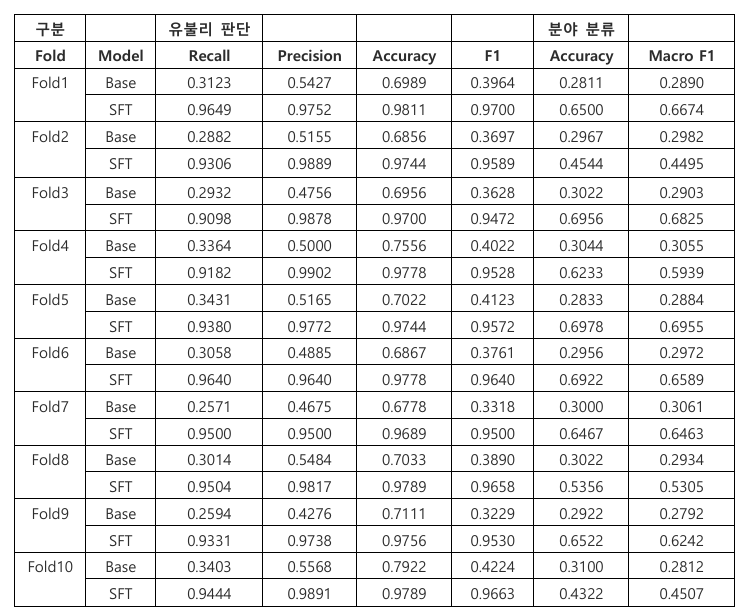

#### (1) 유불리 판단
Base 모델의 경우 Recall이 0.3수준으로 ‘불리’ 약관을 ‘유리’로 잘못 판단하는 비율이 높았다. 그러나 SFT 모델은 약 95% 수준의 Recall을 보여 ‘불리’ 약관을 거의 빠짐없이 잡아낼 수 있게 되었다. 동시에 Precision 또한 대폭 상승했는데, 모델이 불리하다고 지적했을 때 그것이 오답일 확률이 매우 낮아졌음을 의미한다. 결과적으로 F1-Score가 상승하며, SFT적용 이후 모델의 유불리 판단 성능이 유의미하게 상승하였음을 확인하였다.

#### (2) 분야 분류
SFT 적용 후 성능이 향상되었으나, 정확도가 약 60%대 구간에서 머물렀다. 이는 모델의 성능 문제라기보다, 입력 정보의 한계에 기인한것으로 분석하였다. 약관 조항이 여러 데이터에 공통으로 등장하는 범용적인 텍스트로 구성된 경우가 많고, 분류해야 할 타겟 클래스가 43개로 매우 세분화되어 있기 때문에 분류 작업이 어렵다. 현재 모델은 약관 원문만을 입력으로 받고 있는데, 분야 분류의 경우, 약관 원문 조항뿐만 아니라 분쟁 경위 등을 함께 입력받으면 성능을 극대화 할 수 있을 것으로 사료된다.

### 2. 외부 데이터(한국공정거래조정원 분쟁조정사례) 기반 실용성 검증 결과

AI-Hub에서 제공하는 데이터가 아닌, 한국공정거래조정원 분쟁조정사례 데이터를 통해 모델 평가용 데이터셋을 data/ext_data.jsonl 으로 구축하여, **SFT 모델의 일반화 성능**을 확인하였다.

#### (1) 유불리 판단
| 평가지표 | Base Model | SFT Model |
| :--- | :---: | :---: |
| **Accuracy** | 0.5417 | **0.8958** |
| **Precision** | 1.0000 | **1.0000** |
| **Recall** | 0.5417 | **0.8958** |
| **F1 Score** | 0.7027 | **0.9451** |

Base 모델은 실제 불공정 사례의 절반 정도만 탐지했으나, SFT 모델은 약 90%를 찾아내며 외부  데이터에서도 불리 약관을 거의 빠짐없이 잡아내었다.

#### (2) 분야 분류
| 평가지표 | Base Model | SFT Model |
| :--- | :---: | :---: |
| **Accuracy** | 0.3333 | **0.5000** |
| **Macro F1** | 0.2594 | **0.2721** |

Accuracy가 0.33에서 0.50으로 상승하여 SFT의 효과를 확인하였으나, 불공정 판단 과제에 비해서는 성능 향상 폭이 제한적이었다. 이는 앞서 분석한 바와 같이, 약관 텍스트만으로는 세분화된 43개 카테고리를 명확히 구분하는 데 정보량이 부족하기 때문인 것으로 보인다. 그러나 전혀 새로운 외부 데이터에 대해서도 50%의 정확도를 달성한 것은, 모델이 최소한의 도메인 적응력을 갖추었음을 시사한다. 그러나 Accuracy의 큰 상승폭에 비해 Macro F1 Score의 상승은 상대적으로 미미하였다. 이는 모델의 성능 향상이 데이터가 많은 주요 메이저 카테고리에 집중되었음을 시사한다. 학습 데이터와 현실 분쟁 데이터 간의 간극이 존재하며, 특히 데이터가 희소한 세부 계약 분야까지 완벽하게 일반화하기 위해서는 추가적인 데이터 확보 전략이 필요함을 보여준다.


본 프로젝트의 초기 단계에서는 법률 도메인에 특화된 것으로 알려진 nlpai-lab/KURE-v1 모델을 그대로 사용하였다. 약관 원문만으로 법령을 검색하는 실험 결과, Recall@1 지표가 0.0889에 그치는 저조한 성능을 보였다. 이를 해결하기 위해 2단계 성능 고도화 전략을 수립하고 실행하였다. 
#### (1) 임베딩 모델 파인튜닝
근본적인 모델 성능 향상을 위해 약관과 정답 법령을 매칭시킨 데이터셋으로 Retriever 모델 자체를 재학습시켰다.  

#### (2) LLM이 생성한 ‘법률적 판단 근거’를 활용한 쿼리 확장
 단순 약관 텍스트만으로는 정보가 부족하다고 판단하여, SFT 모델이 생성한 법률적 판단 근거를 검색어에 포함시켰다. LLM이 생성한 텍스트에는 "약관법 제6조", "신의성실의 원칙" 등 법령과 유사한 전문 용어가 포함되어 있어, 검색 모델이 정답 법령과 매칭될 확률을 높여줄 것으로 가설을 세웠다. 



다음은 임베딩 모델을 파인튜닝하는 코드이다. 

#### (1) 데이터 구성

build_dataset_from_file 함수를 통해 약관 조항과 그에 매칭되는 정답 법령을 쌍으로 구성하였다.

#### (2) 대조 학습

손실 함수로 MultipleNegativesRankingLoss를 채택하였다.
이는 학습 배치 내에서 정답 쌍 간의 유사도는 극대화하고, 배치 내의 다른 샘플들은 오답으로 간주하여 거리를 멀어지게 하는 방식이다. 이를 통해 모델이 약관과 법령 사이의 의미적 연관성을 더 명확히 학습하도록 유도하였다.

In [ ]:
import json
import random
import os
from pathlib import Path
from datasets import Dataset 
from sentence_transformers import (
    SentenceTransformer,
    losses,
    SentenceTransformerTrainer,
    SentenceTransformerTrainingArguments
)

ROOT = Path(".")

TRAIN_DATA_PATH = ROOT / "data" / "retriever_train.jsonl"
VAL_DATA_PATH   = ROOT / "data" / "retriever_val.jsonl"

LAW_DB_PATH = ROOT / "data" / "law_db.json"
OUTPUT_DIR  = ROOT / "models" / "kure-law-retriever"

def load_law_db():
    if not LAW_DB_PATH.exists():
        raise FileNotFoundError(f"법령 DB 파일이 없습니다: {LAW_DB_PATH}")
    with LAW_DB_PATH.open("r", encoding="utf-8") as f:
        law_list = json.load(f)
    return { int(r["id"]): r["law_text"] for r in law_list }

def build_dataset_from_file(file_path, law_db):
    anchors = []
    positives = []
    
    print(f"데이터 로드 중: {file_path}")
    if not file_path.exists():
        raise FileNotFoundError(f"파일이 없습니다: {file_path}")

    with file_path.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line: continue
            
            ex = json.loads(line)
            clause = ex.get("input", "")
            gt_ids = ex.get("ground_truth_ids", [])
            
            if not clause or not gt_ids: continue
            
            # 정답 중 하나 랜덤 선택
            pos_id = random.choice(gt_ids)
            pos_text = law_db.get(int(pos_id))
            
            if not pos_text: continue
            
            anchors.append(clause)
            positives.append(pos_text)

    print(f" - 데이터 개수: {len(anchors)}")
    
    # HuggingFace Dataset 객체 반환
    return Dataset.from_dict({
        "anchor": anchors,
        "positive": positives
    })

def main():
    #  법령 DB 로드
    id2text = load_law_db()
    
    #  Train / Val 데이터셋 로드
    print("\n[Train Dataset]")
    train_dataset = build_dataset_from_file(TRAIN_DATA_PATH, id2text)
    
    print("\n[Val Dataset]")
    eval_dataset = build_dataset_from_file(VAL_DATA_PATH, id2text)

    #  모델 로드
    model = SentenceTransformer("nlpai-lab/KURE-v1")

    train_loss = losses.MultipleNegativesRankingLoss(model)

    args = SentenceTransformerTrainingArguments(
        output_dir=str(OUTPUT_DIR),
        num_train_epochs=1,             
        per_device_train_batch_size=2,  
        per_device_eval_batch_size=2,  
        gradient_accumulation_steps=8, 
        learning_rate=2e-5,            
        warmup_steps=100,               
        fp16=True,                   
        logging_steps=10,             
        save_strategy="epoch",          
        
        eval_strategy="epoch",          
    )

    #  Trainer 실행
    trainer = SentenceTransformerTrainer(
        model=model,
        args=args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,      
        loss=train_loss,
    )

    print("\n학습 시작...")
    trainer.train()
    
    # 저장
    model.save_pretrained(str(OUTPUT_DIR))
    print(f"\n학습 및 저장 완료: {OUTPUT_DIR}")

if __name__ == "__main__":
    main()


/home/ally010314/llm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



[Train Dataset]
데이터 로드 중: data/retriever_train.jsonl
 - 데이터 개수: 2430

[Val Dataset]
데이터 로드 중: data/retriever_val.jsonl
 - 데이터 개수: 270



학습 시작...


Epoch,Training Loss,Validation Loss
1,0.462500,0.382678



학습 및 저장 완료: models/kure-law-retriever


앞서 학습된 모델의 성능을 검증하고 실제 검색 시스템에 적용하기 위해, 법령 데이터베이스(data/law_db.jsonl)를 벡터 인덱스로 변환하는 과정을 수행하였다.

특히 성능 고도화 효과를 정량적으로 확인하기 위해, (1) Base KURE-v1과 (2) 파인튜닝된 모델 각각에 대하여 동일한 절차로 인덱싱을 진행하여 비교 평가를 위한 환경을 구축하였다.

In [ ]:
import os
import faiss
import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm
from sentence_transformers import SentenceTransformer

JSON_PATH = "data/law_db.json" 
INDEX_DIR = "rag_index"
#Base Kure-v1
EMBEDDING_MODEL = os.environ.get("EMB_MODEL", "nlpai-lab/KURE-v1")
#tuned model
#EMBEDDING_MODEL = "models/kure-law-retriever"

BATCH = 128


def get_model(name: str):
    print(f"[Embedding] loading: {name}")
    model = SentenceTransformer(name)
    return model


def e5_encode_query(text: str) -> str:
    return "passage: " + text.strip()


def main():
    os.makedirs(INDEX_DIR, exist_ok=True)
    df = pd.read_json(JSON_PATH)
    assert "law_text" in df.columns, "JSON에 'law_text' 필드가 필요합니다."

    df = df.drop_duplicates(subset=["law_text"]).reset_index(drop=True)
    print(f"[Data] unique rows: {len(df)}")

    model = get_model(EMBEDDING_MODEL)
    texts = [e5_encode_query(t) for t in df["law_text"].tolist()]

    # 배치 임베딩
    all_vecs = []
    for i in tqdm(range(0, len(texts), BATCH), desc="Embedding"):
        batch = texts[i:i + BATCH]
        vecs = model.encode(batch, normalize_embeddings=True, convert_to_numpy=True)
        all_vecs.append(vecs)

    X = np.vstack(all_vecs).astype("float32")
    dim = X.shape[1]

    # FAISS Index
    index = faiss.IndexFlatIP(dim)
    index.add(X)
    faiss.write_index(index, os.path.join(INDEX_DIR, "faiss.index"))

    #메타데이터 저장 (id, law_text만 유지)
    meta = []
    for _, row in df.iterrows():
        meta.append({
            "id": int(row["id"]),
            "file_name": None,        
            "law_text": row["law_text"],
        })

    with open(os.path.join(INDEX_DIR, "meta.pkl"), "wb") as f:
        pickle.dump(meta, f)

    with open(os.path.join(INDEX_DIR, "dim.txt"), "w", encoding="utf-8") as f:
        f.write(str(dim))

    print(f"vectors={len(df)}, dim={dim}")
    print(f"- FAISS : {os.path.join(INDEX_DIR, 'faiss.index')}")
    print(f"- META  : {os.path.join(INDEX_DIR, 'meta.pkl')}")
    print(f"- DIM   : {os.path.join(INDEX_DIR, 'dim.txt')}")


if __name__ == "__main__":
    main()


[Data] unique rows: 38
[Embedding] loading: nlpai-lab/KURE-v1


Embedding: 100%|██████████| 1/1 [00:03<00:00,  3.71s/it]

vectors=38, dim=1024
- FAISS : rag_index/faiss.index
- META  : rag_index/meta.pkl
- DIM   : rag_index/dim.txt


다음 코드는 성능 비교의 기준점을 마련하기 위해, 파인튜닝되지 않은 초기 모델(Base KURE-v1)을 사용하여 검색 성능을 평가하는 스크립트이다.

실험 조건은 다음과 같이 설정되었다.


모델: nlpai-lab/KURE-v1 (Base 모델) 


쿼리(Query): 약관 원문 텍스트 (판단 근거 등 추가 정보 없음) 


평가 지표: Recall@K (1, 3, 5, 10), MRR, nDCG@5

In [ ]:
import json
import os
import pickle
import numpy as np
import faiss
import math
from pathlib import Path
from tqdm import tqdm
from sentence_transformers import SentenceTransformer

ROOT = Path(".")
DATA_PATH = ROOT / "data" / "retriever_val.jsonl"

BASE_MODEL_NAME = "nlpai-lab/KURE-v1"

INDEX_PATH = ROOT / "rag_index" / "faiss.index"
META_PATH  = ROOT / "rag_index" / "meta.pkl"

def load_resources():
    print(f"Base 모델 로드 중: {BASE_MODEL_NAME}")
    embedder = SentenceTransformer(BASE_MODEL_NAME)
    
    print(f"인덱스 로드 중: {INDEX_PATH}")
    if not INDEX_PATH.exists():
        raise FileNotFoundError(f"인덱스 파일이 없습니다: {INDEX_PATH}")
        
    index = faiss.read_index(str(INDEX_PATH))
    
    with open(META_PATH, "rb") as f:
        meta = pickle.load(f)
        
    return embedder, index, meta

def calculate_metrics(hits, gt_ids):
    # Recall
    r1  = 1.0 if any(h in gt_ids for h in hits[:1]) else 0.0
    r3  = 1.0 if any(h in gt_ids for h in hits[:3]) else 0.0
    r5  = 1.0 if any(h in gt_ids for h in hits[:5]) else 0.0
    r10 = 1.0 if any(h in gt_ids for h in hits[:10]) else 0.0
    
    # MRR
    mrr = 0.0
    for rank, h in enumerate(hits, 1):
        if h in gt_ids:
            mrr = 1.0 / rank
            break
            
    # nDCG@5
    dcg = 0.0
    for rank, h in enumerate(hits[:5], 1):
        if h in gt_ids:
            dcg = 1.0 / math.log2(rank + 1)
            break
            
    return r1, r3, r5, r10, mrr, dcg

def main():
    # 1. 리소스 로드
    embedder, index, meta = load_resources()
    
    # 2. 데이터 로드
    print(f"평가 데이터 로드: {DATA_PATH}")
    with open(DATA_PATH, "r", encoding="utf-8") as f:
        data = [json.loads(line) for line in f if line.strip()]
        
    print(f"\n[Case 1: Base Model] 평가 시작 (총 {len(data)}개)...")
    
    stats = {"r1": 0.0, "r3": 0.0, "r5": 0.0, "r10": 0.0, "mrr": 0.0, "ndcg5": 0.0}
    cnt = 0
    
    for ex in tqdm(data):
        clause = ex.get("input", "")
        gt_ids = set(ex.get("ground_truth_ids", []))
        
        if not gt_ids: continue
        
        query = clause
        
        vec = embedder.encode([query], normalize_embeddings=True)
        _, I = index.search(vec.astype("float32"), 10)
        
        pred_ids = []
        for idx in I[0]:
            if idx == -1: continue
            pred_ids.append(meta[int(idx)]["id"])
            
        r1, r3, r5, r10, mrr, ndcg = calculate_metrics(pred_ids, gt_ids)
        
        stats["r1"] += r1
        stats["r3"] += r3
        stats["r5"] += r5
        stats["r10"] += r10
        stats["mrr"] += mrr
        stats["ndcg5"] += ndcg
        cnt += 1
        
    if cnt == 0:
        print("평가할 데이터가 없습니다.")
        return

    for k in stats: stats[k] /= cnt
    
    print("\n" + "="*40)
    print(f"[Case 1 결과] KURE-v1 Base Model")
    print("="*40)
    print(f"Recall@1  : {stats['r1']:.4f}")
    print(f"Recall@3  : {stats['r3']:.4f}")
    print(f"Recall@5  : {stats['r5']:.4f}")
    print(f"Recall@10 : {stats['r10']:.4f}")
    print(f"MRR       : {stats['mrr']:.4f}")
    print(f"nDCG@5    : {stats['ndcg5']:.4f}")
    print("="*40)

if __name__ == "__main__":
    main()

Base 모델 로드 중: nlpai-lab/KURE-v1
인덱스 로드 중: rag_index/faiss.index
평가 데이터 로드: data/retriever_val.jsonl

[Case 1: Base Model] 평가 시작 (총 270개)...


100%|██████████| 270/270 [00:17<00:00, 15.22it/s]



[Case 1 결과] KURE-v1 Base Model
Recall@1  : 0.0889
Recall@3  : 0.2111
Recall@5  : 0.2926
Recall@10 : 0.4556
MRR       : 0.1847
nDCG@5    : 0.1964


다음 코드는 파인튜닝된 Retriever 모델(Tuned KURE-v1)을 대상으로, **(Step 1) 임베딩 모델 최적화 효과**와 **(Step 2) 쿼리 확장 전략의 유효성**을 검증하기 위한 평가 스크립트이다.

이 코드는 동일한 모델 및 인덱스 환경에서 입력 쿼리의 구성만을 달리하여 두 가지 Case를 비교 실험한다.
평가 데이터(retriever_val.jsonl)에는 사전에 파인튜닝된 Llama 모델이 생성한 응답(sft_answer)이 포함되어 있으며, 이를 활용하여 입력 쿼리(Query)의 구성을 달리한 두 가지 비교 실험을 수행한다.

##### Step 1

쿼리: 약관 조항 원문

목적: 파인튜닝된 모델이 기존 Base 모델 대비 얼마나 성능이 향상되었는지 확인한다.

##### Step 2

쿼리: 약관 조항 원문 + SFT 모델이 생성한 법률적 판단 근거 (input + sft_answer 내 근거)

목적: LLM이 생성한 '판단 근거'를 검색어에 추가했을 때, 정답 법령 검색 성능이 추가로 개선되는지 검증한다.

In [ ]:
import json
import os
import pickle
import numpy as np
import faiss
import math
from pathlib import Path
from tqdm import tqdm
from sentence_transformers import SentenceTransformer

ROOT = Path(".")
DATA_PATH = ROOT / "data" / "retriever_val.jsonl" 


MODEL_PATH = ROOT / "models" / "kure-law-retriever"
INDEX_PATH = ROOT / "rag_index_retriever" / "faiss.index" 
META_PATH  = ROOT / "rag_index_retriever" / "meta.pkl"    

def load_resources():
    print(f" Fine-tuned 모델 로드: {MODEL_PATH}")
    embedder = SentenceTransformer(str(MODEL_PATH))
    
    print(f" FAISS 인덱스 로드: {INDEX_PATH}")
    if not INDEX_PATH.exists():
        raise FileNotFoundError(f"인덱스 파일이 없습니다: {INDEX_PATH}")
        
    index = faiss.read_index(str(INDEX_PATH))
    with open(META_PATH, "rb") as f:
        meta = pickle.load(f)
    return embedder, index, meta

def parse_reason_from_answer(answer_line: str) -> str:
    """
    sft_answer 문자열: "분야: 3 / 불공정여부: 불리 / 근거: ......"
    여기서 '근거: ' 뒤의 텍스트만 추출함.
    """
    if not answer_line:
        return ""
        
    parts = [p.strip() for p in answer_line.split("/") if p.strip()]
    
    for p in parts:
        if p.startswith("근거:"):
            return p.replace("근거:", "").strip()
            
    return ""

def calculate_metrics(hits, gt_ids):
    # Recall
    r1  = 1.0 if any(h in gt_ids for h in hits[:1]) else 0.0
    r3  = 1.0 if any(h in gt_ids for h in hits[:3]) else 0.0
    r5  = 1.0 if any(h in gt_ids for h in hits[:5]) else 0.0
    r10 = 1.0 if any(h in gt_ids for h in hits[:10]) else 0.0
    
    # MRR
    mrr = 0.0
    for rank, h in enumerate(hits, 1):
        if h in gt_ids:
            mrr = 1.0 / rank
            break
    # nDCG@5
    dcg = 0.0
    for rank, h in enumerate(hits[:5], 1):
        if h in gt_ids:
            dcg = 1.0 / math.log2(rank + 1)
            break
    return r1, r3, r5, r10, mrr, dcg 

def evaluate(name, data, embedder, index, meta, mode):
    print(f"\n [{name}] 평가 중...")
    stats = {"r1": 0.0, "r3": 0.0, "r5": 0.0, "r10": 0.0, "mrr": 0.0, "ndcg5": 0.0}
    cnt = 0
    
    for ex in tqdm(data):
        clause = ex.get("input", "")
        gt_ids = set(ex.get("ground_truth_ids", []))
        if not gt_ids: continue
        
        if mode == "reason": 
            sft_ans = ex.get("sft_answer", "")
            
            reason = parse_reason_from_answer(sft_ans)
            
            if reason and reason != "해당 없음":
                query = f"{clause}\n\n판단근거: {reason}"
            else:
                query = clause
        else:
            query = clause
            
        vec = embedder.encode([query], normalize_embeddings=True)
        _, I = index.search(vec.astype("float32"), 10)
        
        pred_ids = []
        for idx in I[0]:
            if idx == -1: continue
            pred_ids.append(meta[int(idx)]["id"])
            
        r1, r3, r5, r10, mrr, ndcg = calculate_metrics(pred_ids, gt_ids)
        stats["r1"] += r1
        stats["r3"] += r3
        stats["r5"] += r5
        stats["r10"] += r10
        stats["mrr"] += mrr
        stats["ndcg5"] += ndcg
        cnt += 1
        
    for k in stats: stats[k] /= cnt
    return stats

def main():
    embedder, index, meta = load_resources()
    
    print(f" 데이터 로드: {DATA_PATH}")
    with open(DATA_PATH, "r", encoding="utf-8") as f:
        data = [json.loads(line) for line in f if line.strip()]
        
    res_case2 = evaluate("Case 2: Only Clause (Fine-tuned)", data, embedder, index, meta, mode="clause")
    
    res_case1 = evaluate("Case 3: Clause + Reason (Fine-tuned)", data, embedder, index, meta, mode="reason")
    
    print("\n" + "="*60)
    print(f"{'Metric':<10} | {'Case 2 (Only Clause)':<22} | {'Case 3 (+Reason)':<22}")
    print("-" * 60)
    for k in ["r1", "r3", "r5", "r10", "mrr", "ndcg5"]:
        diff = res_case1[k] - res_case2[k]
        print(f"{k:<10} | {res_case2[k]:.4f}                 | {res_case1[k]:.4f} ({diff:+.4f})")
    print("="*60)

if __name__ == "__main__":
    main()

 Fine-tuned 모델 로드: models/kure-law-retriever
 FAISS 인덱스 로드: rag_index_retriever/faiss.index
 데이터 로드: data/retriever_val.jsonl

 [Case 2: Only Clause (Fine-tuned)] 평가 중...


100%|██████████| 270/270 [04:08<00:00,  1.09it/s]



 [Case 3: Clause + Reason (Fine-tuned)] 평가 중...


100%|██████████| 270/270 [07:46<00:00,  1.73s/it]


Metric     | Case 2 (Only Clause)   | Case 3 (+Reason)      
------------------------------------------------------------
r1         | 0.3778                 | 0.3926 (+0.0148)
r3         | 0.6185                 | 0.6148 (-0.0037)
r5         | 0.6926                 | 0.7148 (+0.0222)
r10        | 0.8370                 | 0.8519 (+0.0148)
mrr        | 0.5235                 | 0.5332 (+0.0097)
ndcg5      | 0.5519                 | 0.5647 (+0.0128)


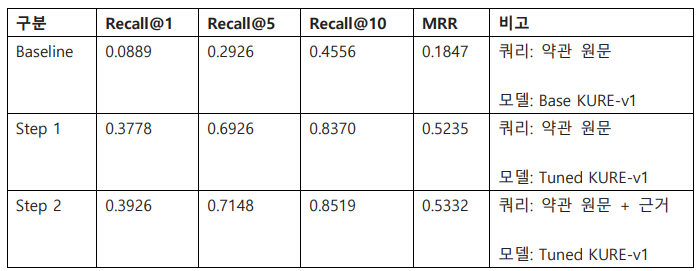

**1. Retriever 모델 파인튜닝 효과 (Baseline vs Step 1)**

검색 쿼리를 '약관 원문'으로 통제한 상태에서 임베딩 모델의 성능을 비교한 실험 결과, 법률 도메인으로 파인튜닝된 Tuned 모델(Step 1)의 Recall@1은 0.3778로, Base 모델(Baseline, 0.0889) 대비 약 325%의 비약적인 성능 향상을 기록하였다. 이는 도메인 특화 학습이 검색 정확도에 결정적인 영향을 미침을 입증한다.

**2. 쿼리 확장(Query Expansion)의 효용성 검증 (Step 1 vs Step 2)**

파인튜닝된 모델을 기반으로, SFT 모델이 생성한 '판단 근거'를 쿼리에 추가했을 때의 성능 변화를 측정한 실험 결과,
Recall@1이 단순 약관 원문만 사용했을 때보다 약 3.9% 추가 상승(0.3778 → 0.3926)하여, 근거 텍스트가 검색의 정확도를 보완함을 확인하였다.
MRR은 0.5235에서 0.5332로 개선되었다. 이는 쿼리 확장이 단순히 정답을 찾는 것을 넘어, 정답 법령을 검색 결과의 더 상위권으로 끌어올리는 데 실질적인 기여를 했음을 시사한다.